# 1. Importação das bibliotecas

In [ ]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt

# 2. Definição de Variáveis Globais

In [ ]:
classes = ["NENHUM", "PESSOA"]

base_path = path_result

EPOCHS = 40

BATCH_SIZE = 100

DIM = 96


# 3. Função para Carregar e Processar uma Imagem

In [ ]:
def load_image(image_path):

    image = cv2.imread(image_path)
    image = cv2.resize(image, (DIM, DIM))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image


# 4. Função para Carregar o Dataset

In [ ]:
def load_dataset(base_path, classes):

    data = []
    labels = []

    os.chdir(base_path)


    for i in range(len(classes)):
        path = base_path+"/"+classes[i]

        j = 0
        with os.scandir(path) as files:

            for file in files:

                try:

                    image = load_image(file.path)

                    if image.shape[0] >= DIM:
                        data.append(image)
                        labels.append(i)

                except:
                    pass

    data = np.array(data, dtype="float32") / 255.0
    labels = np.array(labels)

    return data, labels

# 5. Carregamento do Dataset e Separação em Treinamento e Validação

In [ ]:
data, labels = load_dataset(base_path, classes)

print(data.shape)
print(labels.shape)

(40, 96, 96, 3)
(40,)


In [ ]:
train_features, validation_features, train_labels, validation_labels = train_test_split(data, labels, test_size=0.2, random_state=0)

print('# of training images:', train_features.shape[0])
print('# of cross-validation images:', validation_features.shape[0])

X_train, y_train = train_features, train_labels
X_validation, y_validation = validation_features, validation_labels


# of training images: 32
# of cross-validation images: 8


# 6. Aplicação de Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
)

train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)


# 7. Criação do Modelo Base (MobileNet)

In [ ]:
base_model = keras.applications.MobileNet(
    weights='imagenet',
    input_shape=(DIM, DIM, 3),
    alpha=0.25,
    include_top=False
    )

base_model.trainable = False

base_model.summary()


<ipython-input-106-0fd0921f1056>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNet(


Model: "mobilenet_0.25_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 48, 48, 8)           │             216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 48, 48, 8)           │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 48, 48, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 48, 48, 8)           │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 48, 48, 8)           │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 48, 48, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 48, 48, 16)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 48, 48, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 49, 49, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 24, 24, 16)          │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 24, 24, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 24, 24, 32)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 24, 24, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 24, 24, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 24, 24, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 24, 24, 32)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 218,544 (853.69 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 218,544 (853.69 KB)

# 8. Adaptação do Modelo para a Classificação

In [ ]:
base_model.trainable = False

last_layer = base_model.get_layer('conv_pw_10_relu')

#x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(last_layer.output)
x = tf.keras.layers.Reshape((-1, last_layer.output.shape[3]))(last_layer.output)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=2, activation='softmax')(x)

model = tf.keras.Model(base_model.input, x)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 48, 48, 8)           │             216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 48, 48, 8)           │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 48, 48, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 48, 48, 8)           │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 48, 48, 8)           │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 48, 48, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 48, 48, 16)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 48, 48, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 49, 49, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 24, 24, 16)          │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 24, 24, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 24, 24, 32)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 24, 24, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 24, 24, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 24, 24, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 24, 24, 32)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 103,858 (405.70 KB)

 Trainable params: 9,218 (36.01 KB)

 Non-trainable params: 94,640 (369.69 KB)

# 9. Compilação e Treinamento

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

In [ ]:
steps_per_epoch = X_train.shape[0] // BATCH_SIZE
validation_steps = X_validation.shape[0] // BATCH_SIZE

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
          validation_data=validation_generator, validation_steps=validation_steps,
          shuffle=True)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5000 - loss: 1.5482 - val_accuracy: 0.5000 - val_loss: 1.0358
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.4375 - loss: 1.5388 - val_accuracy: 0.6250 - val_loss: 0.9179
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.5312 - loss: 1.3755 - val_accuracy: 0.7500 - val_loss: 0.5711
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5000 - loss: 1.0201 - val_accuracy: 0.8750 - val_loss: 0.6086
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.5312 - loss: 0.8559 - val_accuracy: 0.6250 - val_loss: 0.7586
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.4688 - loss: 1.0319 - val_accuracy: 0.6250 - val_loss: 0.6899
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6562 - loss: 0.8704 - val_accuracy: 0.8750 - val_loss: 0.5084
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6875 - loss: 0.7862 - val_accuracy: 0.7500 - val_loss: 0.4055
Epoch 

# 10. Visualização do Desempenho do Treinamento

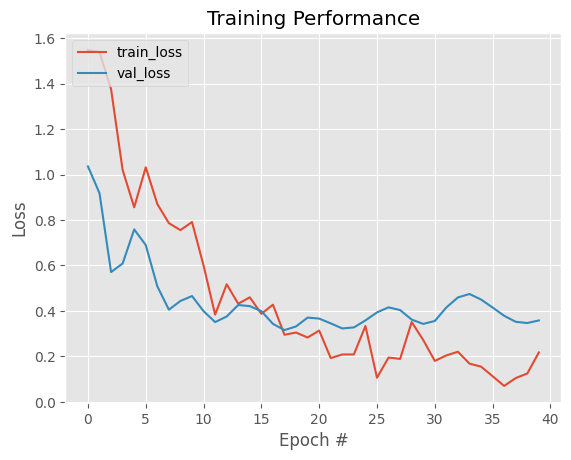

In [ ]:
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")

plt.title("Training Performance")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")

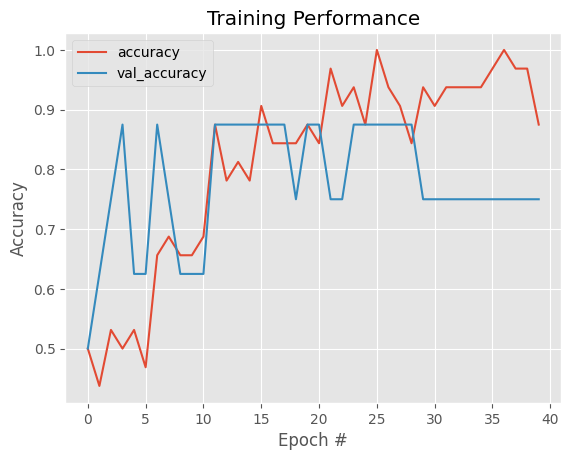

In [ ]:
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), history.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")

plt.title("Training Performance")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

# 11. Avaliação Inicial

In [ ]:
print("Evaluate on test data")
model.evaluate(X_validation, y_validation, batch_size=BATCH_SIZE)

Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7500 - loss: 0.3582


[0.35820403695106506, 0.75]

# 12. Refinamento do Modelo (Fine-Tuning)

In [ ]:
base_model.trainable = True

model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.000045),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=int(EPOCHS/2),
          validation_data=validation_generator, validation_steps=validation_steps,
          shuffle=True)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.8438 - loss: 0.4894 - val_accuracy: 0.7500 - val_loss: 0.3451
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.8750 - loss: 0.3186 - val_accuracy: 0.7500 - val_loss: 0.3652
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step - accuracy: 0.8438 - loss: 0.2885 - val_accuracy: 0.7500 - val_loss: 0.4136
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9688 - loss: 0.1783 - val_accuracy: 0.7500 - val_loss: 0.4753
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step - accuracy: 0.9062 - loss: 0.1848 - val_accuracy: 0.7500 - val_loss: 0.5479
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step - accuracy: 0.9375 - loss: 0.1250 - val_accuracy: 0.7500 - val_loss: 0.6231
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step - accuracy: 0.9688 - loss: 0.1090 - val_accuracy: 0.7500 - val_loss: 0.6917
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step - accuracy: 0.9375 - loss: 0.1420 - val_accuracy: 0.7500 - val_loss: 

# 13. Visualização Após Fine-Tuning

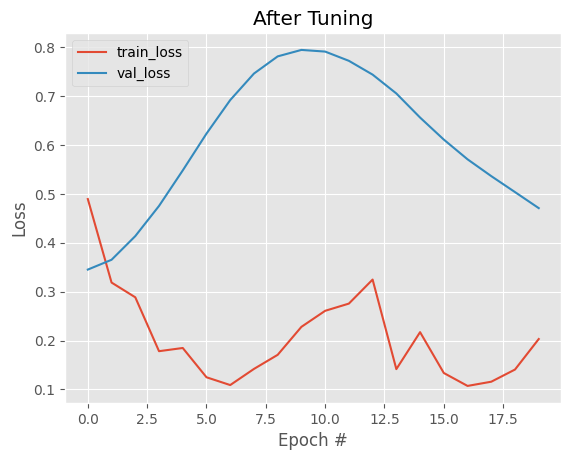

In [ ]:
plt.style.use("ggplot")
plt.figure()
N = int(EPOCHS/2)
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")

plt.title("After Tuning")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")

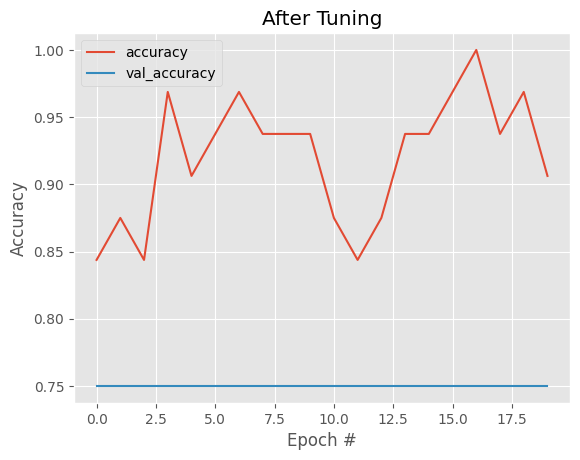

In [ ]:
plt.style.use("ggplot")
plt.figure()
N = int(EPOCHS/2)
plt.plot(np.arange(0, N), history.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")

plt.title("After Tuning")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

In [ ]:
print("Evaluate on test data")
_, model_accuracy = model.evaluate(X_validation, y_validation, batch_size=BATCH_SIZE)

Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7500 - loss: 0.4708


# 14. Salvamento do Modelo Treinado

In [ ]:
tf.keras.models.save_model(
    model, base_path + "/personrecognition-2.keras", overwrite=True, include_optimizer=True
)


# 15. Conversão para TensorFlow Lite

In [ ]:
def representative_dataset_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(data).batch(1).take(BATCH_SIZE):

    yield [input_value]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]

converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_quant_model = converter.convert()

open(base_path+'/personrecognition-2.tflite', "wb").write(tflite_quant_model)

Saved artifact at '/tmp/tmpir35w98j'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='keras_tensor_740')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134163140556752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134163140557136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134163140557712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134163140557328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134163140556176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134163140556560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134163140625040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134163140625424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134163140558672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134163140555792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134163140626

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


157048

In [ ]:
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]


  prediction_digits = []
  for i, test_image in enumerate(data):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))

    test_image = np.array(test_image*255-128, dtype="int8")
    test_image = test_image.reshape(1,DIM,DIM,3)
    interpreter.set_tensor(input_index, test_image)


    interpreter.invoke()

    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')

  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == labels).mean()
  return accuracy

# 16. Avaliação do Modelo Convertido

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Quant TFLite test_accuracy:', test_accuracy)

Evaluated on 0 results so far.


Quant TFLite test_accuracy: 0.95


# 17. Predição em Imagens

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
NENHUM: 99.03%
PESSOA: 0.97%


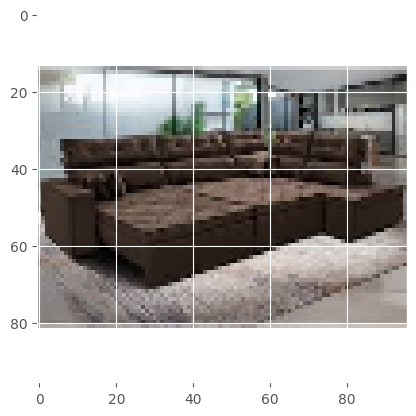

In [ ]:
DIM = 96


image_path = "/content/sofa.jpg"  # pituta


if not os.path.exists(image_path):
    raise FileNotFoundError(f"Arquivo não encontrado: {image_path}")


image = cv2.imread(image_path)


if image is None:
    raise ValueError(f"Erro ao carregar a imagem: {image_path}")

image = cv2.resize(image, (DIM, DIM))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

image = np.array(image / 255, dtype="float32")
image = image.reshape(1, DIM, DIM, 3)


preds = model.predict(image)


for i in range(len(classes)):
    print("{}: {:.2f}%".format(classes[i], preds[0][i] * 100))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
NENHUM: 26.11%
PESSOA: 73.89%


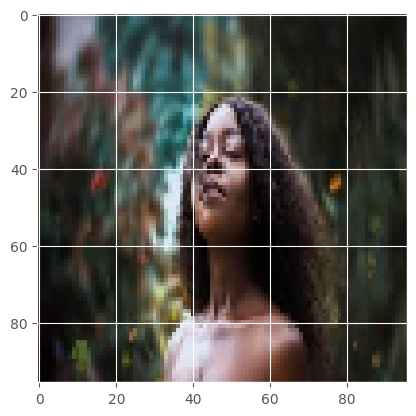

In [ ]:
DIM = 96

image_path = "/content/1.jpg"  # pituta


if not os.path.exists(image_path):
    raise FileNotFoundError(f"Arquivo não encontrado: {image_path}")


image = cv2.imread(image_path)


if image is None:
    raise ValueError(f"Erro ao carregar a imagem: {image_path}")

image = cv2.resize(image, (DIM, DIM))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

image = np.array(image / 255, dtype="float32")
image = image.reshape(1, DIM, DIM, 3)

preds = model.predict(image)


for i in range(len(classes)):
    print("{}: {:.2f}%".format(classes[i], preds[0][i] * 100))